<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/AL_relaxation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

  ERROR: Failed building wheel for simple-nn


In [2]:
import numpy as np
import random
import copy

import torch

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import BFGS

from amptorch.active_learning.generator_funcs import MDsimulate, Relaxation
from amptorch.model import CustomMSELoss

import dftbook
dftbook.setup_colab()
from espresso import Espresso

/usr/local/lib/python3.6/dist-packages/simple_nn/utils/graph.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/io

Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 19.3 seconds


In [4]:
from ase.utils.eos import EquationOfState
from ase.build import bulk
energies = []
volumes = []
LC = [3.5, 3.55, 3.6, 3.65, 3.7, 3.75]

for a in LC:
  cu_bulk = bulk('Cu', 'fcc', a=a)

  calc = Espresso(xc='PBE',
              pw=500,
              calculation='scf',
              kpts=[12, 12, 12])

  cu_bulk.set_calculator(calc)

  e = cu_bulk.get_potential_energy()
  energies.append(e)
  volumes.append(cu_bulk.get_volume())


eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
aref=3.6
vref = bulk('Cu', 'fcc', a=aref).get_volume()

copper_lattice_constant = (v0/vref)**(1/3)*aref

/usr/local/lib/python3.6/dist-packages/ase/utils/eos.py:5: UserWarning: Moved to ase.eos
  warnings.warn('Moved to ase.eos')


In [0]:
base_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')

In [22]:
from ase import Atoms, Atom
# Define initial set of images, can be as few as 1. If 1, make sure to change train_split to 0.

slab = fcc100("Cu", a=copper_lattice_constant, size=(2, 2, 3))
ads = molecule("C")
add_adsorbate(slab, ads, 3, offset=(1, 1))
cons = FixAtoms(
    indices=[atom.index for atom in slab if (atom.tag == 3)]
)
slab.set_constraint(cons)
slab.center(vacuum=13.0, axis=2)
slab.set_pbc(True)
slab.wrap(pbc=[True] * 3)
slab.set_calculator(copy.copy(base_calc))
slab.set_initial_magnetic_moments()

images = [slab]


# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=8)
Gs["G2_rs_s"] = [0] * 8
Gs["G4_etas"] = [0.005, 0.01]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

# Define morse parameters if Delta-ML model, o/w morse = False
morse_params = {
    "C": {"re": 0.972, "D": 6.379, "sig": 0.477},
    "Cu": {"re": 2.168, "D": 3.8386, "sig": 1.696},
}

training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 3},
      "samples_to_retrain": 5,
      "Gs": Gs,
      "morse": True,
      "morse_params": morse_params,
      "forcetraining": True,
      "cores": 10,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 300,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
}

# Define AL calculator
al_calc = AtomisticActiveLearning(
    parent_calc=base_calc, images=images, filename="relax_example",
    file_dir="./"
)
# Define AL generating function and training scheme.
al_calc.active_learner(
    generating_function=Relaxation(
        initial_geometry=images[0].copy(),
        optimizer=BFGS,
        fmax=0.01,
        steps=50,
    ),
    training_params=training_params
)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.2190          5.5850        0.6478     +  0.0935
      2          0.0197          0.3538        0.0027     +  0.1070
      3          0.0010          0.0996        0.0002     +  0.1079
      4          0.0000          0.0168        0.0000     +  0.1130
      5          0.0000          0.0065        0.0000     +  0.1096
      6          0.0000          0.0017        0.0000     +  0.0610
      7          0.0000          0.0013        0.0000     +  0.0115
      8          0.0000          0.0013        0.0000     +  0.0111
      9          0.0000          0.0013        0.0000     +  0.0125
     10          0.0000          0.0013        0.0000     +  0.0121
     11          0.0000          0.0013        0.0000     +  0.0118
     12          0.0000          0.0013        0.0000     +  0.

In [25]:
# Compute the parent calculator (DFT, etc. - EMT in this case) based relaxation

true_relax = Relaxation(slab, BFGS, fmax=0.01)
true_relax.run(base_calc, 'true_relax')
emt_relax = true_relax.get_trajectory('true_relax', 0, -1, 1)

      Step     Time          Energy         fmax
BFGS:    0 17:45:03   -66067.814979        1.3942
BFGS:    1 17:46:32   -66067.857783        1.4564
BFGS:    2 17:48:15   -66067.946623        1.5722
BFGS:    3 17:49:49   -66068.040737        1.6931
BFGS:    4 17:51:20   -66068.140764        1.8248
BFGS:    5 17:52:48   -66068.247238        1.9566
BFGS:    6 17:54:26   -66068.360795        2.0987
BFGS:    7 17:56:01   -66068.481943        2.2458
BFGS:    8 17:57:45   -66068.610855        2.3891
BFGS:    9 17:59:30   -66068.747826        2.5430
BFGS:   10 18:01:20   -66068.892805        2.6768
BFGS:   11 18:03:10   -66069.046212        2.8151
BFGS:   12 18:05:58   -66069.207127        2.9390
BFGS:   13 18:08:03   -66069.373641        3.0402
BFGS:   14 18:10:03   -66069.544214        3.0896
BFGS:   15 18:12:09   -66069.715126        3.0833
BFGS:   16 18:14:16   -66069.881764        3.0097
BFGS:   17 18:16:24   -66070.038260        2.8166
BFGS:   18 18:18:06   -66070.176750        2.5104
B

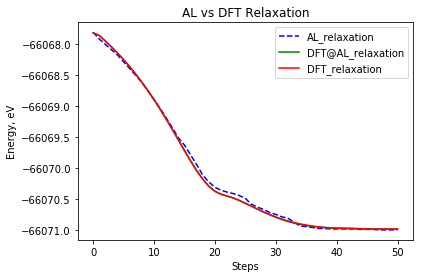

In [34]:
# Visualize Results
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

base_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')

final_ml_traj = ase.io.read("./relax_example_iter_3.traj", ":")
parent_calc_traj = ase.io.read("./true_relax.traj", ":")

#Compute ML predicted energies
ml_relaxation_energies = [image.get_potential_energy() for image in final_ml_traj]
#Compute actual energies for ML predicted structures
parent_evaluated_ml_energies = [copy.copy(base_calc).get_potential_energy(image) for image in final_ml_traj]
#Compute actual energies for parent relaxation structures
parent_relaxation_energies = [image.get_potential_energy() for image in parent_calc_traj]
ml_steps = range(len(final_ml_traj))
parent_steps = range(len(parent_calc_traj))

plt.plot(ml_steps, ml_relaxation_energies, '--b', label='AL_relaxation')
plt.plot(ml_steps, parent_evaluated_ml_energies, '-g', label='DFT@AL_relaxation')
plt.plot(parent_steps, parent_relaxation_energies, '-r', label='DFT_relaxation')
plt.xlabel("Steps")
plt.ylabel("Energy, eV")
plt.title('AL vs DFT Relaxation')
plt.legend()
plt.show()

In [28]:
# Evaluation Metrics
def compute_loss(a, b):
  return np.mean(np.sqrt(np.sum((a - b)**2, axis=1)))

initial_structure = images[0].positions
al_iterations = training_params['al_convergence']['num_iterations']
retrained_samples = training_params['samples_to_retrain']
print(f'Number of AL iterations: {al_iterations}\nNumber of samples/iteration: {retrained_samples}\nTotal # of queries: {al_iterations*retrained_samples}\n')
print(f'Final AL Relaxed Energy: {ml_relaxation_energies[-1]}')
print(f'DFT evaluation at AL structure: {parent_evaluated_ml_energies[-1]}\n')
al_relaxed_structure = final_ml_traj[-1].positions

print(f'Total number of DFT steps: {len(parent_relaxation_energies)}')
print(f'Final DFT Relaxed Energy: {parent_relaxation_energies[-1]}\n')
parent_relaxed_structure = parent_calc_traj[-1].positions


initial_structure_error = compute_loss(initial_structure, parent_relaxed_structure)
relaxed_structure_error = compute_loss(al_relaxed_structure, parent_relaxed_structure)

print(f'Initial structure error: {initial_structure_error}')
print(f'AL relaxed structure error: {relaxed_structure_error}')

Number of AL iterations: 3
Number of samples/iteration: 5
Total # of queries: 15

Final AL Relaxed Energy: -66070.9921875
DFT evaluation at AL structure: -66070.97696289883

Total number of DFT steps: 51
Final DFT Relaxed Energy: -66070.97799353009

Initial structure error: 0.15536472433458878
AL relaxed structure error: 0.003987772464956218
